In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import shap
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Starting enhanced model training with temporal features...")

Starting enhanced model training with temporal features...


In [41]:
df = pd.read_csv('../data/processed/player_features_v2_temporal.csv')

print(f"Dataset loaded")
print(f"Total records: {len(df)}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Dataset loaded
Total records: 2564
Columns: 64

First few rows:
   player_name team   season position  age  games_played  minutes_per_game  \
0   A.J. Green  MIL  2022-23       SG   23            35          9.857143   
1   A.J. Green  MIL  2023-24       SG   24            56         10.964286   
2   A.J. Green  MIL  2024-25       SG   25            73         22.726027   
3  A.J. Lawson  DAL  2022-23       SG   22            14          7.571429   
4  A.J. Lawson  DAL  2023-24       SG   23            42          7.404762   

   points_per_game  rebounds_per_game  assists_per_game  ...  career_ppg_std  \
0         4.400000           1.285714          0.628571  ...        0.000000   
1         4.500000           1.142857          0.535714  ...        0.070711   
2         7.410959           2.383562          1.479452  ...        1.710241   
3         3.857143           1.428571          0.142857  ...        0.000000   
4         3.238095           1.190476          0.476190  ...       

In [42]:
base_features = [
    'age', 'games_played', 'minutes_per_game',
    'points_per_game', 'rebounds_per_game', 'assists_per_game',
    'steals_per_game', 'blocks_per_game', 'turnovers_per_game',
    'field_goal_pct', 'free_throw_pct', 'true_shooting_pct',
    'points_per_minute', 'usage_rate', 'assist_rate', 'rebound_rate'
]

# Lag features from previous seasons (ALL 5 SEASONS)
lag_features = [
    # Points per game - all 5 lags
    'ppg_lag1', 'ppg_lag2', 'ppg_lag3', 'ppg_lag4', 'ppg_lag5',
    # Minutes per game - all 5 lags
    'mpg_lag1', 'mpg_lag2', 'mpg_lag3', 'mpg_lag4', 'mpg_lag5',
    # Rebounds per game
    'rpg_lag1', 'rpg_lag2', 'rpg_lag3',
    # Assists per game
    'apg_lag1', 'apg_lag2', 'apg_lag3',
    # Other key stats
    'spg_lag1', 'bpg_lag1',
    'games_lag1', 'games_lag2', 'games_lag3',
    'ts_pct_lag1', 'ts_pct_lag2', 'ts_pct_lag3',
    'fg_pct_lag1', 'fg_pct_lag2'
]

# Temporal trend features
trend_features = [
    'ppg_trend_2yr', 'ppg_trend_3yr', 'ppg_trend_4yr',
    'mpg_trend_2yr',
    'seasons_in_dataset', 'years_since_peak_ppg', 'peak_ppg',
    'career_ppg_avg', 'career_ppg_std',
    'career_games_avg', 'career_mpg_avg',
    'ppg_coefficient_variation'
]

# Combined feature set
feature_cols = base_features + lag_features + trend_features

# Target variables
target_cols = [
    'target_next_ppg',
    'target_next_rpg',
    'target_next_apg',
    'target_next_mpg',
    'target_next_ts_pct'
]

print(f"\nFeature categories:")
print(f"  Base features: {len(base_features)}")
print(f"  Lag features: {len(lag_features)}")
print(f"  Trend features: {len(trend_features)}")
print(f"  Total features: {len(feature_cols)}")
print(f"  Target variables: {len(target_cols)}")
print(f"\n✓ Feature count matches data preparation output (54 features)")


Feature categories:
  Base features: 16
  Lag features: 26
  Trend features: 12
  Total features: 54
  Target variables: 5

✓ Feature count matches data preparation output (54 features)


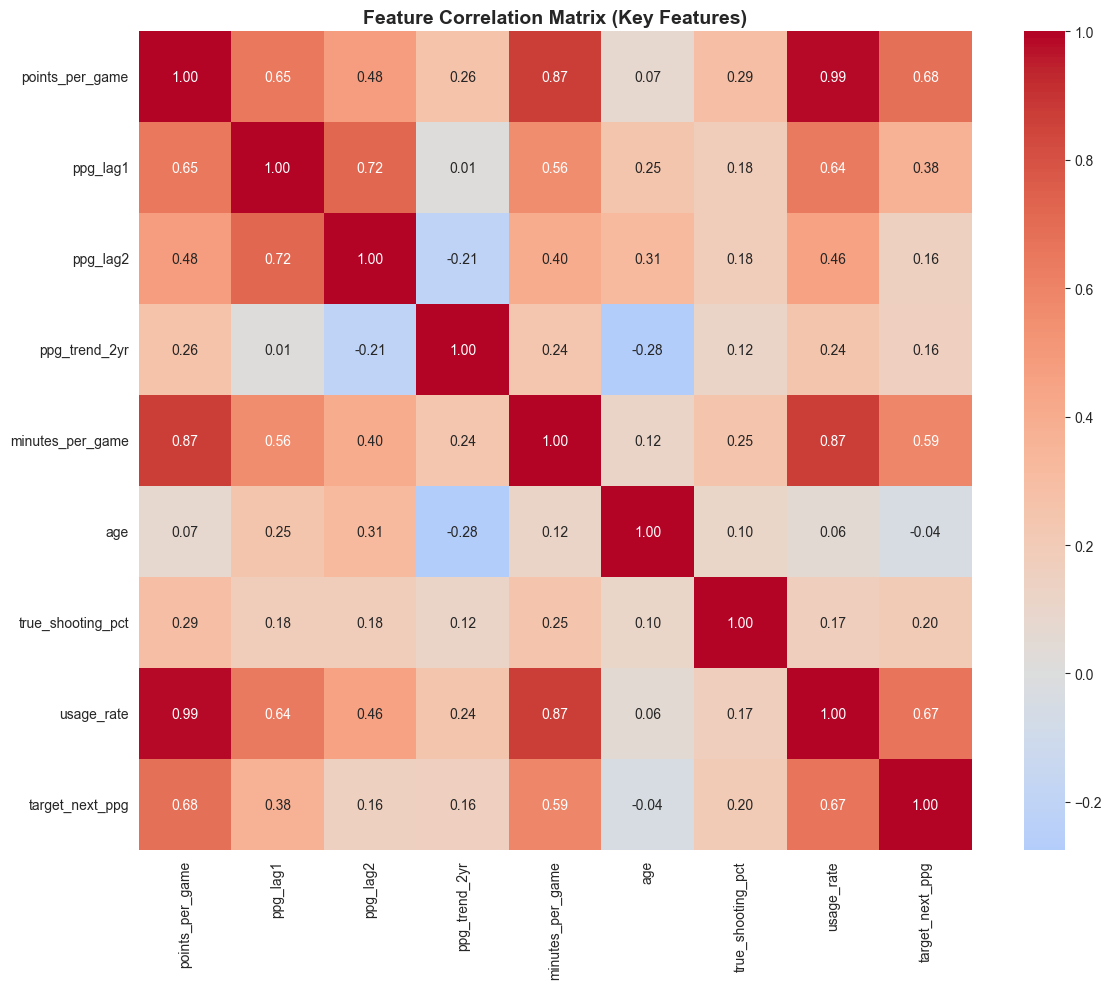


Key correlations with target (next season PPG):
target_next_ppg      1.000000
points_per_game      0.678270
usage_rate           0.666064
minutes_per_game     0.590006
ppg_lag1             0.375833
true_shooting_pct    0.200996
ppg_trend_2yr        0.160928
ppg_lag2             0.155805
age                 -0.044768
Name: target_next_ppg, dtype: float64


In [43]:
key_features = [
    'points_per_game', 'ppg_lag1', 'ppg_lag2', 
    'ppg_trend_2yr', 'minutes_per_game', 'age',
    'true_shooting_pct', 'usage_rate', 'target_next_ppg'
]

corr_matrix = df[key_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Key Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey correlations with target (next season PPG):")
target_corr = corr_matrix['target_next_ppg'].sort_values(ascending=False)
print(target_corr)

In [44]:
print(f"\nTraining Data Quality Check:")
print(f"Total rows in dataframe: {len(df)}")

# CRITICAL FILTER: Exclude inference rows (the latest season where targets are unknown)
latest_season = df['season'].max()
print(f"Filtering out inference season: {latest_season}...")
df_clean_source = df[df['season'] != latest_season]

# Instead of blindly dropping ALL NaNs (which drops rookies/sophomores missing 5 years of lag data),
# we only drop rows where the base points_per_game or targets are missing. XGBoost natively handles NaNs.
df_clean = df_clean_source[feature_cols + target_cols].copy()
df_clean = df_clean.dropna(subset=['points_per_game'] + target_cols)

print(f"Rows available for training after filter: {len(df_clean)}")
if len(df_clean) == 0:
    raise ValueError("ERROR: No training data remaining! Check column names and data.")

X = df_clean[feature_cols]
y = df_clean[target_cols]

print(f"  Features: {X.shape[1]}")
print(f"  Targets: {y.shape[1]}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain-test split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")


Training Data Quality Check:
Total rows in dataframe: 2564
Filtering out inference season: 2024-25...
Rows available for training after filter: 2034
  Features: 54
  Targets: 5

Train-test split:
  Training samples: 1627
  Test samples: 407


In [45]:
print("\nTraining multi-output XGBoost model...")

# Base XGBoost model with regularization
base_model = xgb.XGBRegressor(
    n_estimators=200,   # <--- CHANGED THIS FROM 100 TO 200
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

# Multi-output wrapper
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

print("Training complete")


Training multi-output XGBoost model...
Training complete


In [46]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("=" * 70)
print("MODEL PERFORMANCE")
print("=" * 70)

results = []

for i, target in enumerate(target_cols):
    # Training metrics
    train_mae = mean_absolute_error(y_train.iloc[:, i], y_train_pred[:, i])
    train_r2 = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
    
    # Test metrics
    test_mae = mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i])
    test_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
    test_r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    
    print(f"\n{target}:")
    print(f"  Train MAE: {train_mae:.3f}  |  Test MAE: {test_mae:.3f}")
    print(f"  Train R2:  {train_r2:.3f}  |  Test R2:  {test_r2:.3f}")
    print(f"  Test RMSE: {test_rmse:.3f}")
    
    # Check overfitting
    mae_gap = test_mae - train_mae
    if mae_gap < 0.5:
        status = "Good fit"
    elif mae_gap > 1.0:
        status = "Possible overfitting"
    else:
        status = "Acceptable"
    
    print(f"  Gap: {mae_gap:.3f} ({status})")
    
    results.append({
        'target': target,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'mae_gap': mae_gap
    })

print("=" * 70)

MODEL PERFORMANCE

target_next_ppg:
  Train MAE: 1.348  |  Test MAE: 2.493
  Train R2:  0.941  |  Test R2:  0.778
  Test RMSE: 3.244
  Gap: 1.145 (Possible overfitting)

target_next_rpg:
  Train MAE: 0.536  |  Test MAE: 1.046
  Train R2:  0.931  |  Test R2:  0.682
  Test RMSE: 1.399
  Gap: 0.509 (Acceptable)

target_next_apg:
  Train MAE: 0.353  |  Test MAE: 0.653
  Train R2:  0.947  |  Test R2:  0.776
  Test RMSE: 0.906
  Gap: 0.301 (Good fit)

target_next_mpg:
  Train MAE: 2.504  |  Test MAE: 5.090
  Train R2:  0.913  |  Test R2:  0.592
  Test RMSE: 6.831
  Gap: 2.586 (Possible overfitting)

target_next_ts_pct:
  Train MAE: 0.087  |  Test MAE: 0.117
  Train R2:  0.609  |  Test R2:  0.291
  Test RMSE: 0.176
  Gap: 0.030 (Good fit)


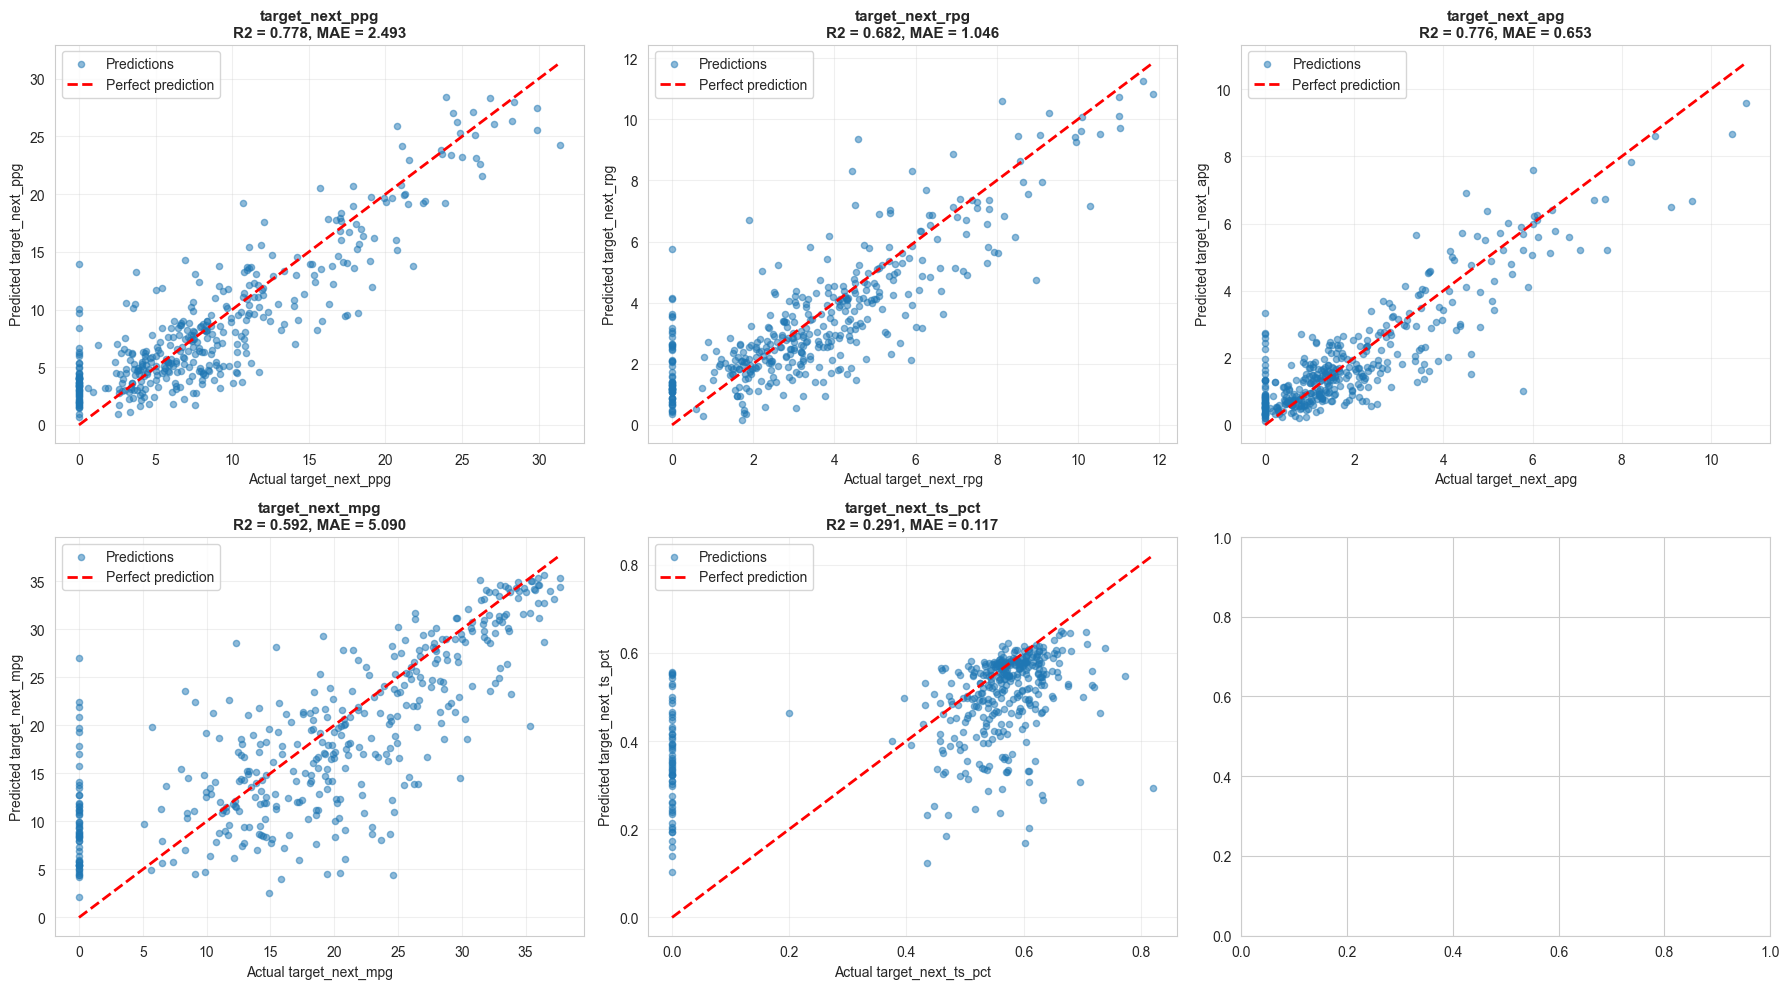

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, target in enumerate(target_cols):
    ax = axes[i]
    
    # Scatter plot
    ax.scatter(y_test.iloc[:, i], y_test_pred[:, i], 
               alpha=0.5, s=20, label='Predictions')
    
    # Perfect prediction line
    min_val = min(y_test.iloc[:, i].min(), y_test_pred[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_test_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            'r--', lw=2, label='Perfect prediction')
    
    # Labels
    ax.set_xlabel(f'Actual {target}', fontsize=10)
    ax.set_ylabel(f'Predicted {target}', fontsize=10)
    ax.set_title(f'{target}\nR2 = {results[i]["test_r2"]:.3f}, MAE = {results[i]["test_mae"]:.3f}',
                 fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

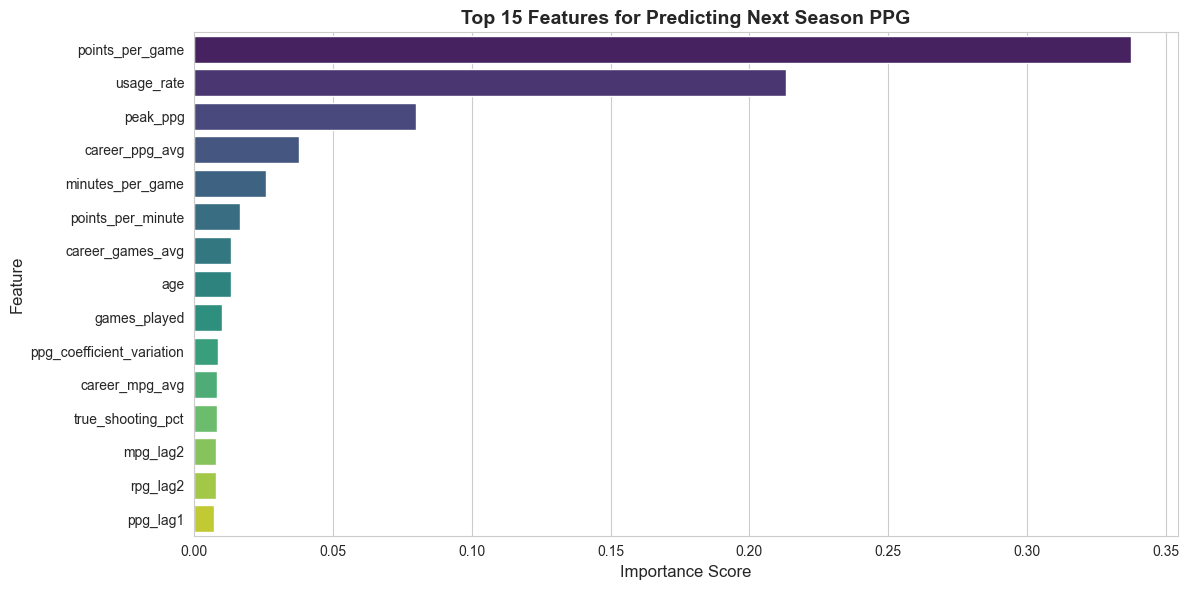


Top 10 most important features:
                      feature  importance
3             points_per_game    0.337511
13                 usage_rate    0.213322
48                   peak_ppg    0.079900
49             career_ppg_avg    0.037660
2            minutes_per_game    0.025932
12          points_per_minute    0.016649
51           career_games_avg    0.013314
0                         age    0.013106
1                games_played    0.010103
53  ppg_coefficient_variation    0.008642


In [48]:
ppg_estimator = model.estimators_[0]
importance = ppg_estimator.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Features for Predicting Next Season PPG', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importance_df.head(10))


Generating SHAP explanations...


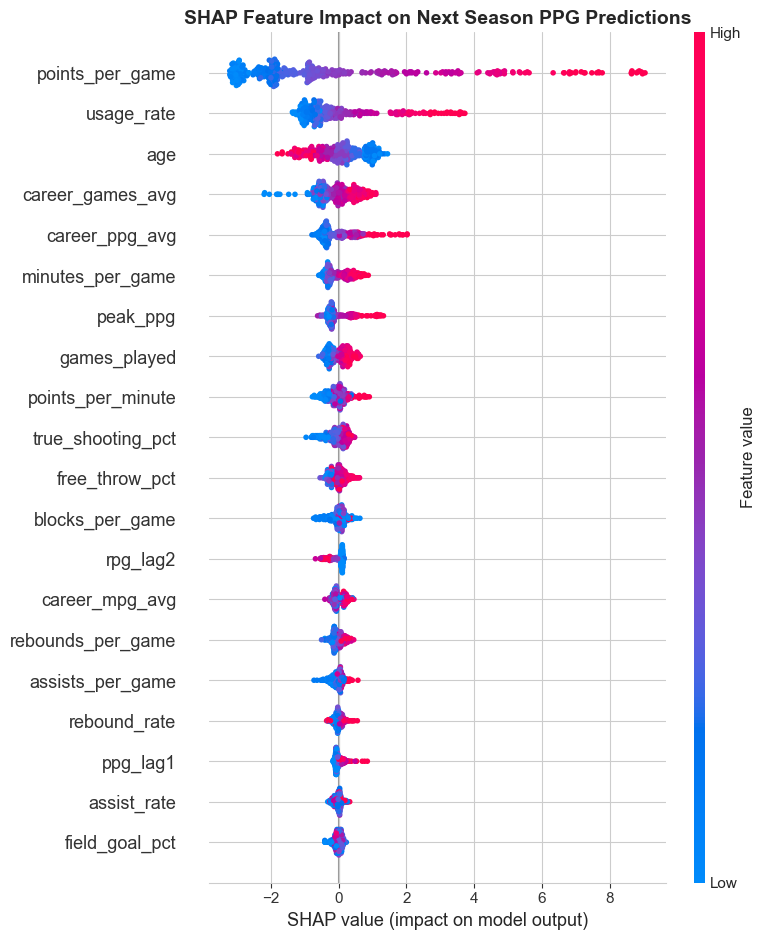

SHAP analysis complete


In [49]:
print("\nGenerating SHAP explanations...")

# Create explainer for first target (PPG)
ppg_estimator = model.estimators_[0]
explainer = shap.TreeExplainer(ppg_estimator)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title('SHAP Feature Impact on Next Season PPG Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("SHAP analysis complete")

In [50]:
print("\nPerforming cross-validation on PPG prediction...")

# Create single-output model for PPG only (for cross-validation)
cv_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1
)

# Cross-validation on PPG target only
cv_scores = cross_val_score(
    cv_model, X, y['target_next_ppg'],
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

cv_mae_scores = -cv_scores

print("\nCross-Validation Results (5-Fold):")
print(f"  Mean MAE: {cv_mae_scores.mean():.3f}")
print(f"  Std MAE:  {cv_mae_scores.std():.3f}")
print(f"  Min MAE:  {cv_mae_scores.min():.3f}")
print(f"  Max MAE:  {cv_mae_scores.max():.3f}")


Performing cross-validation on PPG prediction...

Cross-Validation Results (5-Fold):
  Mean MAE: 2.658
  Std MAE:  0.114
  Min MAE:  2.488
  Max MAE:  2.815


In [51]:
print("\nSample predictions on test set:")
print("=" * 100)

sample_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in sample_indices:
    actual = y_test.iloc[idx]
    predicted = y_test_pred[idx]
    
    print(f"\nSample {idx + 1}:")
    print(f"  Actual next PPG:    {actual['target_next_ppg']:.2f}  |  Predicted: {predicted[0]:.2f}")
    print(f"  Actual next RPG:    {actual['target_next_rpg']:.2f}  |  Predicted: {predicted[1]:.2f}")
    print(f"  Actual next APG:    {actual['target_next_apg']:.2f}  |  Predicted: {predicted[2]:.2f}")
    print(f"  Features: Age={X_test.iloc[idx]['age']:.0f}, PPG={X_test.iloc[idx]['points_per_game']:.1f}, PPG_lag1={X_test.iloc[idx]['ppg_lag1']:.1f}")

print("=" * 100)


Sample predictions on test set:

Sample 227:
  Actual next PPG:    11.08  |  Predicted: 15.46
  Actual next RPG:    11.85  |  Predicted: 10.83
  Actual next APG:    1.24  |  Predicted: 0.96
  Features: Age=26, PPG=15.2, PPG_lag1=0.0

Sample 88:
  Actual next PPG:    7.13  |  Predicted: 6.40
  Actual next RPG:    1.49  |  Predicted: 1.84
  Actual next APG:    1.28  |  Predicted: 0.72
  Features: Age=25, PPG=7.5, PPG_lag1=0.0

Sample 194:
  Actual next PPG:    29.88  |  Predicted: 27.51
  Actual next RPG:    11.61  |  Predicted: 11.24
  Actual next APG:    5.79  |  Predicted: 5.69
  Features: Age=26, PPG=28.1, PPG_lag1=0.0

Sample 330:
  Actual next PPG:    25.89  |  Predicted: 23.18
  Actual next RPG:    7.50  |  Predicted: 7.11
  Actual next APG:    4.76  |  Predicted: 5.63
  Features: Age=21, PPG=22.6, PPG_lag1=20.0

Sample 133:
  Actual next PPG:    4.62  |  Predicted: 5.77
  Actual next RPG:    2.38  |  Predicted: 2.18
  Actual next APG:    0.49  |  Predicted: 1.17
  Features: Age=

In [52]:
import os
from datetime import datetime
import pickle
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)
# 1. Save the multi-output model
with open('../models/player_multioutput_v2.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✓ Saved multi-output model")
# 2. Save SHAP explainer
print("Building per-target SHAP explainers...")
shap_explainers = {}
for i, target in enumerate(target_cols):
    sub_model = model.estimators_[i]
    shap_explainers[target] = shap.TreeExplainer(
        sub_model,
        feature_perturbation="tree_path_dependent"
    )
    print(f"  ✓ SHAP explainer built for {target}")
    
print("Building per-target SHAP explainers...")
shap_explainers = {}
for i, target in enumerate(target_cols):
    sub_model = model.estimators_[i]
    shap_explainers[target] = shap.TreeExplainer(
        sub_model,
        feature_perturbation="tree_path_dependent"
    )
    print(f"  ✓ SHAP explainer built for {target}")
with open('../models/shap_explainers_v2.pkl', 'wb') as f:
    pickle.dump(shap_explainers, f)
print("✓ Saved all SHAP explainers")
# 3. Save feature names
with open('../models/feature_names_v2.txt', 'w') as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")
print(f"✓ Saved {len(feature_cols)} feature names")
# 4. Save target names
with open('../models/target_names_v2.txt', 'w') as f:
    for target in target_cols:
        f.write(f"{target}\n")
print(f"✓ Saved {len(target_cols)} target names")
# 5. Save model metadata
metadata = {
    "model_version": "v2",
    "training_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "n_features": len(feature_cols),
    "n_targets": len(target_cols),
    "n_samples_train": len(X_train),
    "n_samples_test": len(X_test),
    "feature_categories": {
        "base": len(base_features),
        "lag": len(lag_features),
        "trend": len(trend_features)
    },
    "performance": {}
}
# Add performance metrics for each target
for i, target in enumerate(target_cols):
    y_test_target = y_test.iloc[:, i]
    y_pred_target = y_test_pred[:, i]
    
    metadata["performance"][target] = {
        "test_mae": float(mean_absolute_error(y_test_target, y_pred_target)),
        "test_rmse": float(np.sqrt(mean_squared_error(y_test_target, y_pred_target))),
        "test_r2": float(r2_score(y_test_target, y_pred_target))
    }
# Add cross-validation results
metadata["cv_ppg_mean_mae"] = float(cv_scores.mean())
metadata["cv_ppg_std_mae"] = float(cv_scores.std())
with open('../models/model_metadata_v2.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Saved model metadata")
print("\n" + "="*80)
print("MODEL SAVING COMPLETE!")
print("="*80)
print(f"All artifacts saved to ../models/")
print(f"Model Version: {metadata['model_version']}")
print(f"Training Date: {metadata['training_date']}")
print(f"Features: {metadata['n_features']}")
print(f"Targets: {metadata['n_targets']}")
print("="*80)

✓ Saved multi-output model
Building per-target SHAP explainers...
  ✓ SHAP explainer built for target_next_ppg
  ✓ SHAP explainer built for target_next_rpg
  ✓ SHAP explainer built for target_next_apg
  ✓ SHAP explainer built for target_next_mpg
  ✓ SHAP explainer built for target_next_ts_pct
Building per-target SHAP explainers...
  ✓ SHAP explainer built for target_next_ppg
  ✓ SHAP explainer built for target_next_rpg
  ✓ SHAP explainer built for target_next_apg
  ✓ SHAP explainer built for target_next_mpg
  ✓ SHAP explainer built for target_next_ts_pct
✓ Saved all SHAP explainers
✓ Saved 54 feature names
✓ Saved 5 target names
✓ Saved model metadata

MODEL SAVING COMPLETE!
All artifacts saved to ../models/
Model Version: v2
Training Date: 2026-02-22 23:27:43
Features: 54
Targets: 5
